<a href="https://colab.research.google.com/github/fthcknmz/TensorFlow-for-Deep-Learning/blob/main/CatOrDogClassifier_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**



In [1]:
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# **Download the classifier**

*   Download the MobileNet model and create a Keras model from it.
*   MobileNet is expecting images of 224  ×  224 pixels, in 3 color channels (RGB).




In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

# **Run it**

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms.

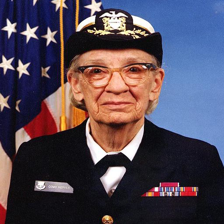

In [3]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [4]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [5]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 8s 8s/step


(1, 1001)

In [6]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

***Decode the predictions***

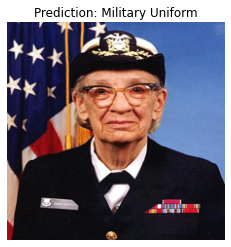

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# **TensorFlow Hub models for the Cats vs. Dogs dataset**

**Load the dataset**

In [8]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

**Resize images in the Dogs vs. Cats dataset**

In [9]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [10]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

# **Run the classifier on a batch of images**

ImageNet has a lot of dogs and cats in it.

In [11]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 543ms/step


array(['Egyptian cat', 'tiger cat', 'dingo', 'Rhodesian ridgeback',
       'Siamese cat', 'Labrador retriever', 'bluetick',
       'Labrador retriever', 'Scotch terrier', 'kelpie',
       'German short-haired pointer', 'kelpie', 'siamang', 'malinois',
       'Egyptian cat', 'golden retriever', 'Cardigan', 'cocker spaniel',
       'toy terrier', 'Christmas stocking', 'Blenheim spaniel',
       'Labrador retriever', 'miniature pinscher', 'Labrador retriever',
       'American Staffordshire terrier', 'American Staffordshire terrier',
       'American Staffordshire terrier', 'Newfoundland', 'tabby',
       'Doberman', 'Persian cat', 'tabby'], dtype='<U30')

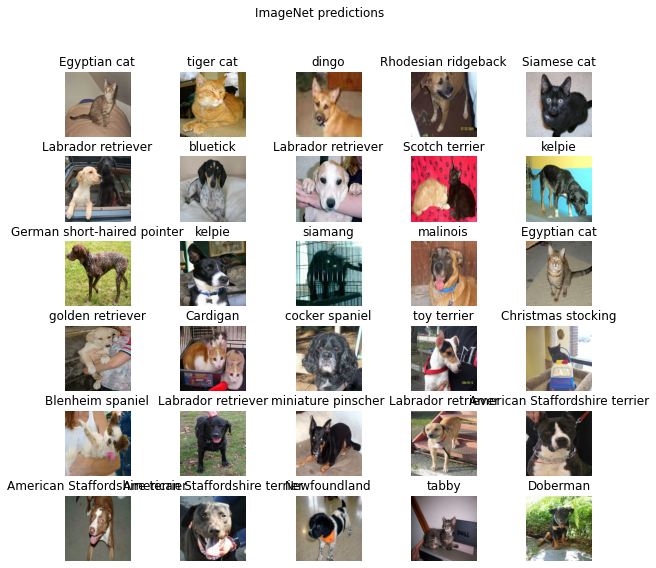

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# **Retrain MobileNet**

Transfer learning with TensorFlow Hub

In [13]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

*Run a batch of images through this, and see the final shape.*

In [14]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


*Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer:*

In [15]:
feature_extractor.trainable = False

*Add a new classification layer:*

In [16]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# **Train the model**

In [17]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 2
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/2


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


582/582 [==============================] - 48s 64ms/step - loss: 0.0515 - accuracy: 0.9825 - val_loss: 0.0338 - val_accuracy: 0.9888
Epoch 2/2
582/582 [==============================] - 115s 189ms/step - loss: 0.0294 - accuracy: 0.9901 - val_loss: 0.0298 - val_accuracy: 0.9910


 *Plot the training and validation accuracy/loss graphs:*

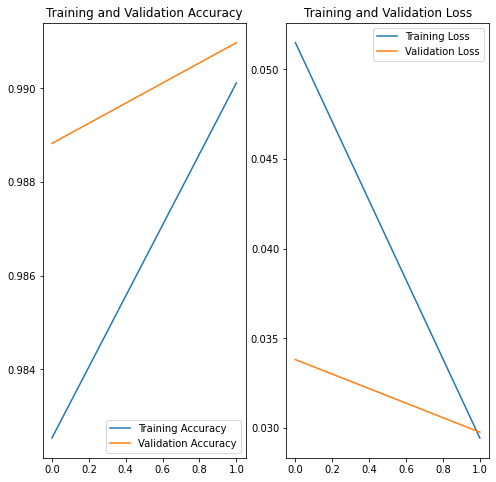

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Predictions**

In [19]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

*Run the image batch through the model and convert the indices to class names.*

In [20]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 532ms/step


array(['cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat',
       'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog',
       'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog',
       'dog', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

*True labels and predicted ones:*

In [21]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0]
Predicted labels:  [0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0]


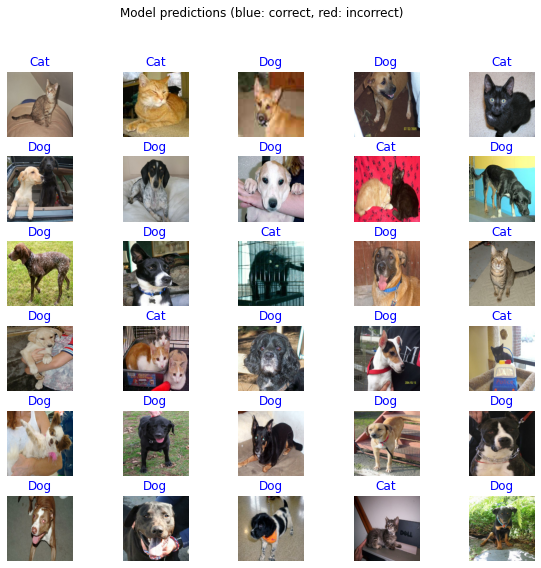

In [22]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")